In [1]:
# 导入合适的库
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# 导入数据
params = np.loadtxt('0915params_2475year.txt')
edpResults = np.loadtxt('0915edpResult_2475year.txt')

In [3]:
params = params[:, (0, 1, 2, 3, 4, 5, 6, 7, 8, 10)]
# params = np.hstack((params, edpResults[:, (0, 1, 2)]))

In [4]:
# 检查params数据是否正确 [T1, mb, kesi, PGA, PGV, PGD, Sd, Sv, Sa]9 theta1: Ia; theta2: D_5-95; theta3: t_mid; theta4: w_mid; theta5: w'; theta6: kesi_f 6 MRVF
#                        0   1    2     3    4    5   6   7   8            9             10             11              12           13            14   
print(params.shape)  
params

(1040, 10)


array([[0.99403126, 1.0700182 , 0.03417537, ..., 1.02971366, 6.958     ,
        7.12847798],
       [0.93152396, 0.93967818, 0.03749781, ..., 1.15154465, 6.958     ,
        8.64177495],
       [1.013555  , 1.11246337, 0.02832358, ..., 1.1174281 , 6.958     ,
        5.05049613],
       ...,
       [1.01654594, 1.11903868, 0.03382425, ..., 1.06458992, 6.958     ,
        6.32783   ],
       [0.99724426, 1.0769466 , 0.04369456, ..., 1.18576913, 6.958     ,
        9.4447874 ],
       [0.9332145 , 0.94309194, 0.04010849, ..., 1.01656765, 6.958     ,
        5.95255981]])

In [5]:
# params = params[:, (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)]
# params.shape

(array([303., 219., 127., 112.,  65.,  50.,  45.,  39.,  51.,  29.]),
 array([6.00706493e-05, 1.78948279e-03, 3.51889493e-03, 5.24830707e-03,
        6.97771921e-03, 8.70713135e-03, 1.04365435e-02, 1.21659556e-02,
        1.38953678e-02, 1.56247799e-02, 1.73541921e-02]),
 <BarContainer object of 10 artists>)

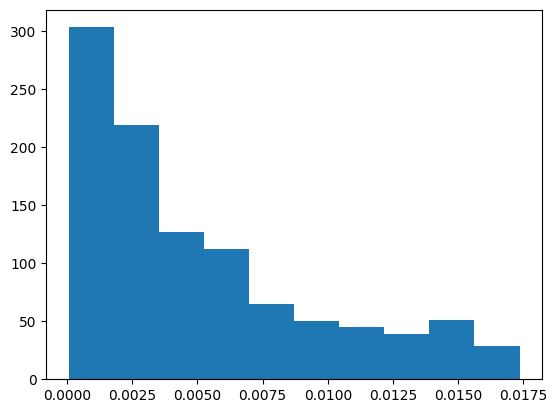

In [6]:
plt.hist(edpResults[:, 7])

In [7]:
# 检查edpResults数据是否正确 [IDR1_MAX, IDR2_MAX, IDR3_MAX, amax0, amax1, amax2, amax3, residual_idr]
print(edpResults.shape)
edpResults = np.log(edpResults)

(1040, 8)


In [8]:
from sklearn.preprocessing import StandardScaler
# 创建 StandardScaler 实例
scaler = StandardScaler()
# 假设 X 是输入特征数据
# 在训练集上拟合（计算均值和方差），并对数据进行标准化
nn = 700
X_train_scaled = scaler.fit_transform(params[:nn])
# 在测试集上使用相同的标准化器进行标准化
X_test_scaled = scaler.transform(params[nn:])

In [9]:
# 数据抓换成torch格式
# n = 6
num, dims = params.shape
train_x = torch.from_numpy(X_train_scaled).to(torch.float)
# train_y = torch.from_numpy(edpResults[:nn, n]).to(torch.float)
train_y = torch.stack([
    torch.from_numpy(edpResults[:nn, 0]).to(torch.float),
    torch.from_numpy(edpResults[:nn, 1]).to(torch.float),
    torch.from_numpy(edpResults[:nn, 2]).to(torch.float),
    torch.from_numpy(edpResults[:nn, 3]).to(torch.float),
    torch.from_numpy(edpResults[:nn, 4]).to(torch.float),
    torch.from_numpy(edpResults[:nn, 5]).to(torch.float),
    torch.from_numpy(edpResults[:nn, 6]).to(torch.float),
], -1)

In [10]:
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([7]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([7]), ard_num_dims=dims),
            batch_shape=torch.Size([7])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=7)
model = BatchIndependentMultitaskGPModel(train_x, train_y, likelihood)

In [11]:
# # We will use the simplest form of GP model, exact inference
# class ExactGPModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=dims))

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# # initialize likelihood and model
# likelihood = gpytorch.likelihoods.GaussianLikelihood()
# model = ExactGPModel(train_x, train_y, likelihood)

In [12]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 200


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    #     i + 1, training_iter, loss.item(),
    #     model.covar_module.base_kernel.lengthscale.item(),
    #     model.likelihood.noise.item()
    # ))
    print('Iter %d/%d' % (i + 1, training_iter))
    print(model.covar_module.base_kernel.lengthscale)
    optimizer.step()

Iter 1/200
tensor([[[0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
          0.6931, 0.6931]],

        [[0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
          0.6931, 0.6931]],

        [[0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
          0.6931, 0.6931]],

        [[0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
          0.6931, 0.6931]],

        [[0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
          0.6931, 0.6931]],

        [[0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
          0.6931, 0.6931]],

        [[0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
          0.6931, 0.6931]]], grad_fn=<SoftplusBackward0>)
Iter 2/200
tensor([[[0.7444, 0.7444, 0.7444, 0.7444, 0.7444, 0.7444, 0.6931, 0.7444,
          0.6931, 0.7444]],

        [[0.7444, 0.7444, 0.7444, 0.7444, 0.7444, 0.7444, 0.6931, 0.7444,
          0.6931, 0.7444]],

        [[0.7444, 0.74

In [13]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.from_numpy(X_test_scaled).to(torch.float)
    observed_pred_test = likelihood(model(test_x))

In [14]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.from_numpy(X_test_scaled).to(torch.float)
    observed_pred_test = likelihood(model(test_x))

In [15]:
from sklearn.metrics import r2_score
for n in range(7):
    r_squared_sklearn_test = r2_score(np.exp(edpResults[nn:, n]), np.exp(observed_pred_test.mean.numpy()[:, n]))
    print(r_squared_sklearn_test)

0.9946433447019539
0.9893964669347449
0.9748085136248624
0.9999577282776373
0.9636809599469052
0.9560573948520792
0.9585548935659489


In [16]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # test_x = torch.from_numpy(params[1600:]).to(torch.float)
    observed_pred_train = likelihood(model(train_x))

c:\ProgramData\miniconda3\envs\torchenv310\lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [17]:
from sklearn.metrics import r2_score
r_squared_sklearn_train = r2_score(edpResults[:nn, n], observed_pred_train.mean.numpy())
print(r_squared_sklearn_train)

ValueError: y_true and y_pred have different number of output (1!=7)

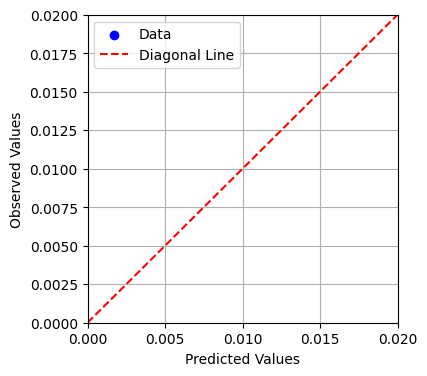

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 生成示例数据（模拟预测值和观测值）
np.random.seed(0)
# observed_values = edpResults[:1600, 0]
# predicted_values = observed_pred_train.mean.numpy()
observed_values = np.exp(edpResults[nn:, n])
predicted_values = np.exp(observed_pred_test.mean.numpy())
# 绘制散点图和对角线
a = 4
plt.figure(figsize=(4,4))
plt.scatter(predicted_values, observed_values, color='blue', label='Data')
plt.plot([0, a], [0, a], color='red', linestyle='--', label='Diagonal Line')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.xlim([0, 0.02])
plt.ylim([0, 0.02])
# plt.title('QQ Plot with Diagonal Line')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
np.savetxt('pidr1_ob.txt', observed_values)
np.savetxt('pidr1_pr.txt', predicted_values)

In [ ]:
from sklearn.metrics import r2_score
r_squared_sklearn_test = r2_score(observed_values, predicted_values)
print(r_squared_sklearn_test)

0.9848355629972843


In [ ]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(observed_values, predicted_values)
print(np.sqrt(MSE))

0.010269827848219929


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 生成示例数据（模拟预测值和观测值）
# np.random.seed(0)
# # observed_values = edpResults[:1600, 0]
# # predicted_values = observed_pred_train.mean.numpy()
# observed_values = np.exp(edpResults[:700, n])
# predicted_values = np.exp(observed_pred_train.mean.numpy())
# # 绘制散点图和对角线
# a = 0.1
# plt.figure(figsize=(4,4))
# plt.scatter(predicted_values, observed_values, color='blue', label='Data')
# plt.plot([0, a], [0, a], color='red', linestyle='--', label='Diagonal Line')
# plt.xlabel('Predicted Values')
# plt.ylabel('Observed Values')
# plt.xlim([0, 0.04])
# plt.ylim([0, 0.04])
# # plt.title('QQ Plot with Diagonal Line')
# plt.legend()
# plt.grid(True)
# plt.show()